In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class SRDataset(Dataset):
    def __init__(self, hr_folder, lr_folder, transform=None):
        self.hr_images = [os.path.join(hr_folder, x) for x in os.listdir(hr_folder)]
        self.lr_images = [os.path.join(lr_folder, x) for x in os.listdir(hr_folder)]
        self.transform = transform

    def __getitem__(self, index):
        hr_image = Image.open(self.hr_images[index])
        lr_image = Image.open(self.lr_images[index])

        if self.transform:
            hr_image = self.transform(hr_image)
            lr_image = self.transform(lr_image)

        return {'lr': lr_image, 'hr': hr_image}

    def __len__(self):
        return len(self.hr_images)

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset and DataLoader
hr_folder = '/app/SRGAN/HR/HR'
lr_folder = '/app/SRGAN/LR/LR'
dataset = SRDataset(hr_folder, lr_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


# Samples from Dataset

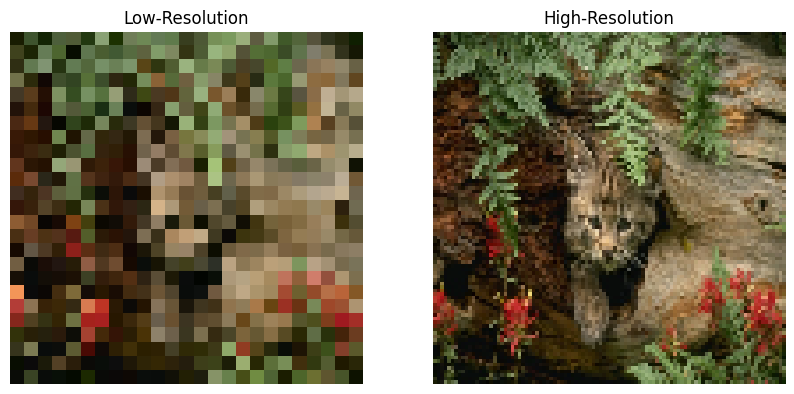

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


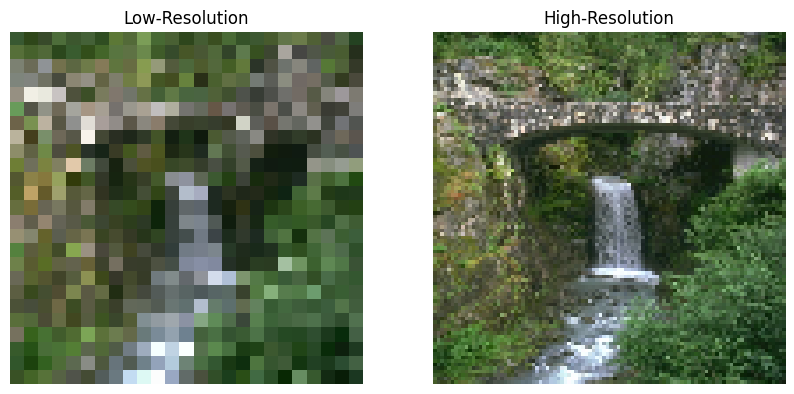

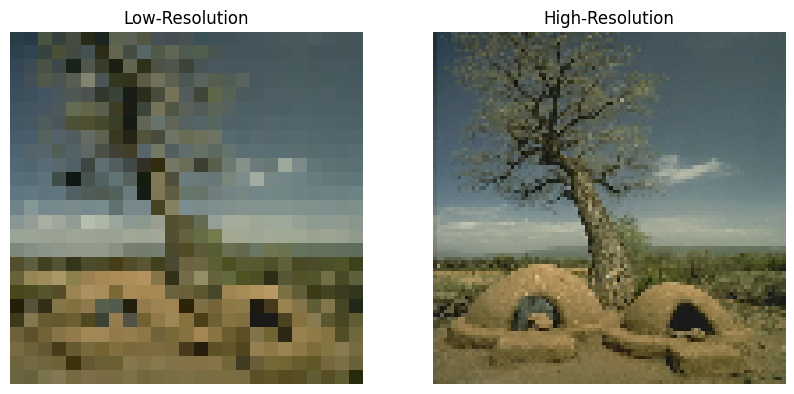

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms

# Function to show images
def show_images(lr_image, hr_image):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Convert tensors to numpy for visualization
    lr_image_np = lr_image.permute(1, 2, 0).numpy()
    hr_image_np = hr_image.permute(1, 2, 0).numpy()

    # Normalize the images to display properly
    lr_image_np = (lr_image_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    hr_image_np = (hr_image_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]

    axs[0].imshow(lr_image_np)
    axs[0].set_title('Low-Resolution')
    axs[0].axis('off')

    axs[1].imshow(hr_image_np)
    axs[1].set_title('High-Resolution')
    axs[1].axis('off')

    plt.show()

# Fetch and display images
for i, data in enumerate(dataloader):
    if i >= 3:  # Display first 3 pairs
        break
    show_images(data['lr'][0], data['hr'][0])


# Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.models import vgg19
import math


class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [ ]:
import argparse
import os
import numpy as np
import math
import itertools
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable


import torch.nn as nn
import torch.nn.functional as F
import torch



hr_shape = (265,256)

# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(3, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()



# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Model Training

In [ ]:


# ----------
#  Training
# ----------

n_epochs=250
for epoch in range(0, n_epochs):
    for i, imgs in enumerate(dataloader):

        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(torch.Tensor))
        imgs_hr = Variable(imgs["hr"].type(torch.Tensor))

        # Generate a high-resolution image from low-resolution input
        gen_hr = generator(imgs_lr)

        # Get the output shape dynamically from the discriminator
        output_shape = discriminator(gen_hr).shape

        # Adversarial ground truths adjusted to the correct output shape
        valid = Variable(torch.Tensor(np.ones(output_shape)), requires_grad=False)
        fake = Variable(torch.Tensor(np.zeros(output_shape)), requires_grad=False)

        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)

        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)

        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())

        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN

        loss_G.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # Log Progress
        print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {loss_D.item()}] [G loss: {loss_G.item()}]")

      # Save images at the end of each epoch
    os.makedirs("saved_images", exist_ok=True)
    save_image(gen_hr.data, f"saved_images/gen_hr_{epoch}.png", nrow=1, normalize=True)
    save_image(imgs_hr.data, f"saved_images/hr_{epoch}.png", nrow=1, normalize=True)




[Epoch 0/250] [Batch 0/128] [D loss: 0.6271358728408813] [G loss: 2.1094675064086914]
[Epoch 0/250] [Batch 1/128] [D loss: 0.4575306177139282] [G loss: 1.7455302476882935]
[Epoch 0/250] [Batch 2/128] [D loss: 0.6894503831863403] [G loss: 2.303976535797119]
[Epoch 0/250] [Batch 3/128] [D loss: 0.7428293824195862] [G loss: 2.273052930831909]
[Epoch 0/250] [Batch 4/128] [D loss: 0.41743025183677673] [G loss: 1.915718674659729]
[Epoch 0/250] [Batch 5/128] [D loss: 0.3234313130378723] [G loss: 2.1976752281188965]
[Epoch 0/250] [Batch 6/128] [D loss: 0.3350050747394562] [G loss: 1.5208684206008911]
[Epoch 0/250] [Batch 7/128] [D loss: 0.39222410321235657] [G loss: 1.8946598768234253]
[Epoch 0/250] [Batch 8/128] [D loss: 0.3820909559726715] [G loss: 1.52888822555542]
[Epoch 0/250] [Batch 9/128] [D loss: 0.35848188400268555] [G loss: 1.7042614221572876]
[Epoch 0/250] [Batch 10/128] [D loss: 0.3092433214187622] [G loss: 1.9662284851074219]
[Epoch 0/250] [Batch 11/128] [D loss: 0.241843432188034

# Save Model

In [ ]:
def save_model(generator, discriminator, optimizer_G, optimizer_D, epoch):

      checkpoint = {
          'generator_state_dict': generator.state_dict(),
          'discriminator_state_dict': discriminator.state_dict(),
          'optimizer_G_state_dict': optimizer_G.state_dict(),
          'optimizer_D_state_dict': optimizer_D.state_dict(),
          # You can also save the epoch number, loss values, etc., if you want
          'epoch': epoch
      }

      # Save the checkpoint
      torch.save(checkpoint, '/app/SRGAN/srgan_checkpoint.pth')

In [ ]:
save_model(generator, discriminator, optimizer_G, optimizer_D, n_epochs)

In [ ]:
# Set to evaluation mode
generator.eval()
discriminator.eval()

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13):

# Test Image Validation

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms


class TestSRDataset(Dataset):
    def __init__(self, lr_folder, transform=None):
        self.lr_images = [os.path.join(lr_folder, x) for x in os.listdir(lr_folder)]
        self.transform = transform

    def __getitem__(self, index):
        lr_image = Image.open(self.lr_images[index])

        if self.transform:
            lr_image = self.transform(lr_image)

        return {'lr': lr_image}

    def __len__(self):
        return len(self.lr_images)

# Transformations

# Transformations with resizing
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset and DataLoader with resizing
lr_folder = '/app/SRGAN/Test/Test'
test_dataset = TestSRDataset(lr_folder, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


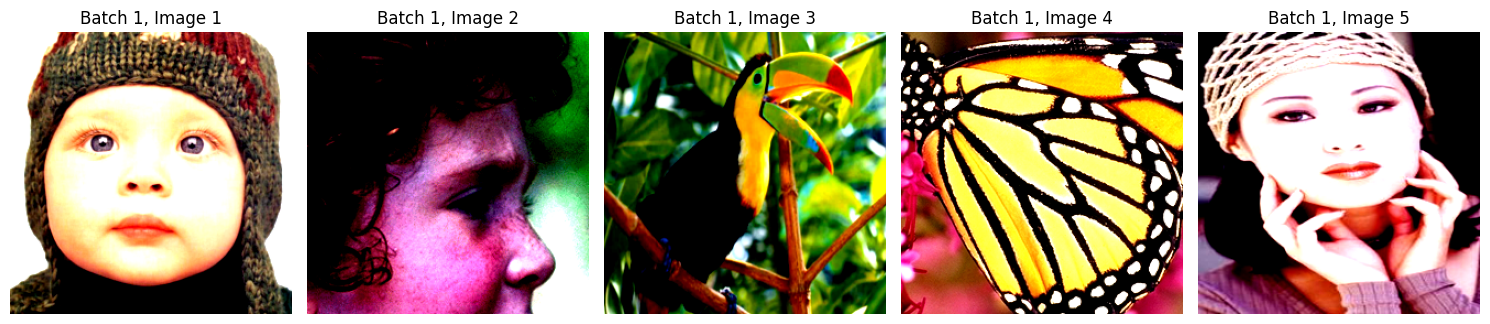

In [ ]:
import matplotlib.pyplot as plt

def show_batch_images(dataloader):
    plt.figure(figsize=(15, 10))
    for i, data in enumerate(dataloader):
        lr_images = data['lr']
        batch_size = lr_images.size(0)

        # Plot each image in the batch
        for j in range(batch_size):
            ax = plt.subplot(len(dataloader), batch_size, i * batch_size + j + 1)
            lr_image = lr_images[j].permute(1, 2, 0).cpu().numpy()
            lr_image = (lr_image * 0.5) + 0.5  # Undo normalization
            plt.imshow(lr_image)
            plt.title(f'Batch {i+1}, Image {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display all images from the test dataloader
show_batch_images(test_dataloader)


In [ ]:
import os
import torch
from torchvision.utils import save_image

# Ensure the generator is in evaluation mode and moved to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
generator.eval()

# Directory to save generated images
output_folder = '/content/drive/MyDrive/DL_Lab2/SRGAN_Model/generated_test_images'
os.makedirs(output_folder, exist_ok=True)

total_images = 0  # Counter to track the number of images processed

with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        # Move LR images to the device
        lr_images = data['lr'].to(device)

        # Generate super-resolved images
        sr_images = generator(lr_images)

        # Save each image in the batch to the folder
        for j, sr_image in enumerate(sr_images):
            save_path = os.path.join(output_folder, f'sr_image_{i * len(sr_images) + j}.png')
            save_image(sr_image.cpu(), save_path, normalize=True)
            total_images += 1  # Increment the counter for each saved image
            print(f"Saved: {save_path}")  # Print path of saved image for verification

print(f"All generated images are saved in {output_folder}. Total images processed: {total_images}")


Saved: /content/drive/MyDrive/DL_Lab2/SRGAN_Model/generated_test_images/sr_image_0.png
Saved: /content/drive/MyDrive/DL_Lab2/SRGAN_Model/generated_test_images/sr_image_1.png
Saved: /content/drive/MyDrive/DL_Lab2/SRGAN_Model/generated_test_images/sr_image_2.png
Saved: /content/drive/MyDrive/DL_Lab2/SRGAN_Model/generated_test_images/sr_image_3.png
Saved: /content/drive/MyDrive/DL_Lab2/SRGAN_Model/generated_test_images/sr_image_4.png
All generated images are saved in /content/drive/MyDrive/DL_Lab2/SRGAN_Model/generated_test_images. Total images processed: 5


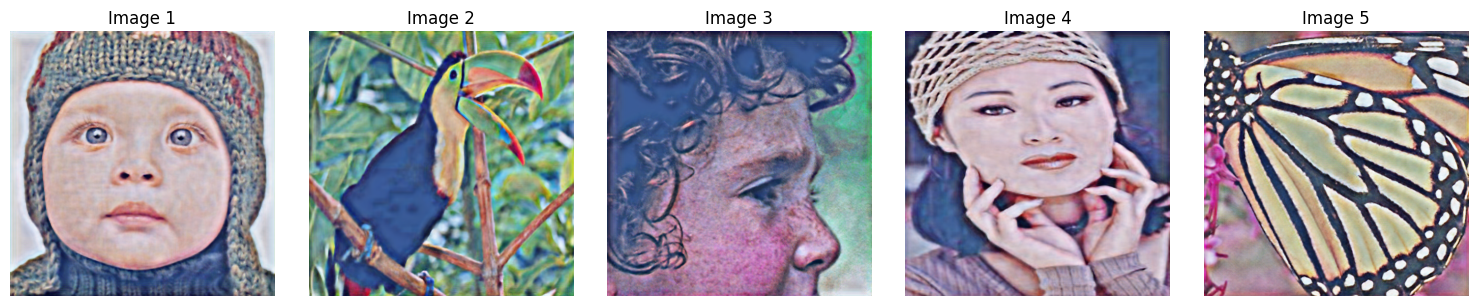

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def display_images_from_folder(folder):
    # Get list of all image files in the folder
    image_files = [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith('.png')]
    image_files.sort()  # Optional: sort files by name

    # Number of images
    num_images = len(image_files)
    cols = 10 # Define how many columns you want in your display
    rows = (num_images + cols - 1) // cols  # Calculate required rows

    plt.figure(figsize=(cols * 3, rows * 3))  # Adjust display size

    # Loop through all the images
    for index, image_file in enumerate(image_files):
        img = Image.open(image_file)
        plt.subplot(rows, cols, index + 1)
        plt.imshow(img)
        plt.title(f'Image {index + 1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Path to the folder containing your generated images
image_folder = '/content/drive/MyDrive/DL_Lab2/SRGAN_Model/generated_test_images'
display_images_from_folder(image_folder)
